# Experimenting with different chunk sizes

In [1]:
from rolling.pdf import list_pdfs, read_pdf
pdfs = list_pdfs()
len(pdfs), pdfs[:3]

(1020,
 ['./arxiv_downloads\\0808.2870v1.Measuring_Distance_and_Properties_of_the_Milky_Way_s_Central_Supermassive_Black_Hole_with_Stellar_Orbits.pdf',
  './arxiv_downloads\\0809.4677v1.Approaching_the_event_horizon__1_3mm_VLBI_of_SgrA_.pdf',
  './arxiv_downloads\\0812.0743v2.A_Novel_Clustering_Algorithm_Based_on_Quantum_Games.pdf'])

In [2]:
paper = read_pdf(pdfs[0])
len(paper.split(' '))

17368

In [3]:
from rolling.embedding import GTEEmbeddingModel
model = GTEEmbeddingModel()
model.max_size

8192

In [5]:
# see how adding a word changes the embedding
words = paper.split(' ')
sentences = []
text = ""
for word in words:
    text += word + " "
    sentences.append(text.strip())

len(sentences), sentences[:5]

(17368,
 ['arXiv:0808.2870v1',
  'arXiv:0808.2870v1 [astro-ph]',
  'arXiv:0808.2870v1 [astro-ph] 21',
  'arXiv:0808.2870v1 [astro-ph] 21 Aug',
  'arXiv:0808.2870v1 [astro-ph] 21 Aug 2008'])

In [5]:
embeddings = model.encode(sentences, batch_size=1, progressbar=True)

100%|██████████| 9543/9543 [06:37<00:00, 24.01it/s] 


In [ ]:
from rolling.embedding import get_similarity

changes = []
for txt_from in range(1, len(embeddings)):
    emb1 = embeddings[txt_from-1]
    emb2 = embeddings[txt_from]
    change = 1 - get_similarity(emb1, emb2)
    changes.append(change)

len(changes), changes[:5]

(9542,
 [np.float16(0.08936),
  np.float16(0.004395),
  np.float16(0.007324),
  np.float16(0.03418),
  np.float16(0.004883)])

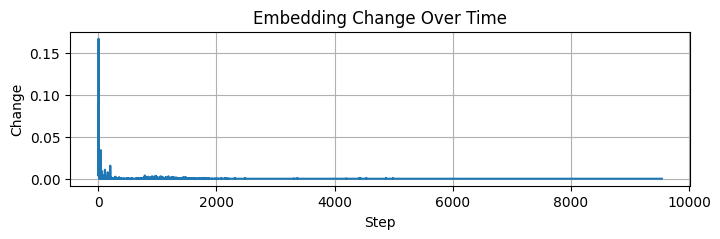

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
# plt.xlim(0.6, 1.0)
plt.plot(changes)
plt.title("Embedding Change Over Time")
plt.xlabel("Step")
plt.ylabel("Change")
plt.grid(True)
plt.show()

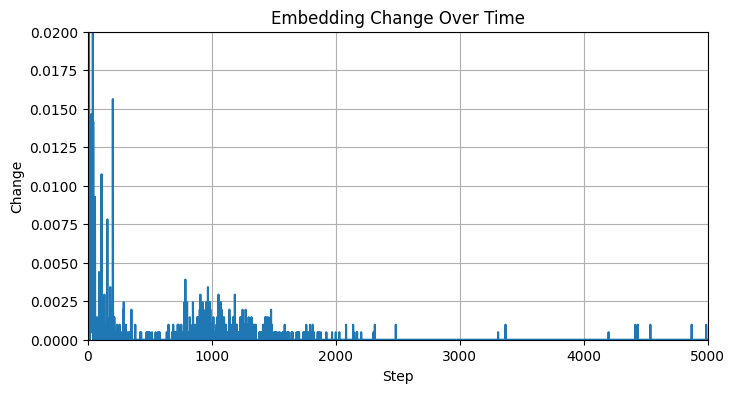

In [19]:
plt.figure(figsize=(8, 4))
plt.ylim(0, 0.02)
plt.xlim(0, 5000)
plt.plot(changes)
plt.title("Embedding Change Over Time")
plt.xlabel("Step")
plt.ylabel("Change")
plt.grid(True)
plt.show()

---
# Download selected papers

In [4]:
import os
download_dir = './arxiv_downloads'
if not os.path.exists(download_dir):
    os.mkdir(download_dir)

In [ ]:
import arxiv

def download_if_new(result:arxiv.Result):
    filename = result._get_default_filename()
    filepath = os.path.join(download_dir, filename)
    if os.path.exists(filepath):
        print(f'Skipping {result.entry_id}')
        return
    
    try:
        result.download_pdf(dirpath=download_dir) #, download_domain="arxiv.org") # just temporarly to fix corrupt pdfs download
        print(f'Downloaded {result.entry_id}')
    except Exception as e:
        print(f"Error downloading {filename}: {e}")
        return None
    return filepath

In [5]:
papers_cow_ids = (
    '2105.09782', '1811.09918', '2106.03643', '1005.1381', '2203.09606', '2101.10445', '2307.13994', '2405.15550', '2110.07103', '2407.20372'
)
papers_blackhole_ids = (
    '1511.08596', 'astro-ph/0611950', '0808.2870', '0906.1492', '1302.5116', 'astro-ph/9809222', 'astro-ph/0003433', '0906.5351', '0809.4677', '1805.05051'
)

In [6]:
client = arxiv.Client()

for result in client.results(arxiv.Search(id_list=papers_cow_ids)):
    download_if_new(result)
for result in client.results(arxiv.Search(id_list=papers_blackhole_ids)):
    download_if_new(result)

Downloaded http://arxiv.org/abs/2105.09782v2
Skipping http://arxiv.org/abs/1811.09918v1
Downloaded http://arxiv.org/abs/2106.03643v1
Skipping http://arxiv.org/abs/1005.1381v2
Skipping http://arxiv.org/abs/2203.09606v1
Skipping http://arxiv.org/abs/2101.10445v1
Skipping http://arxiv.org/abs/2307.13994v1
Skipping http://arxiv.org/abs/2405.15550v1
Skipping http://arxiv.org/abs/2110.07103v1
Skipping http://arxiv.org/abs/2407.20372v1
Skipping http://arxiv.org/abs/1511.08596v1
Downloaded http://arxiv.org/abs/astro-ph/0611950v2
Downloaded http://arxiv.org/abs/0808.2870v1
Skipping http://arxiv.org/abs/0906.1492v2
Skipping http://arxiv.org/abs/1302.5116v1
Downloaded http://arxiv.org/abs/astro-ph/9809222v1
Downloaded http://arxiv.org/abs/astro-ph/0003433v1
Skipping http://arxiv.org/abs/0906.5351v1
Downloaded http://arxiv.org/abs/0809.4677v1
Skipping http://arxiv.org/abs/1805.05051v3


In [6]:
from rolling.pdf import list_pdfs, read_pdf
pdfs = list_pdfs()

paths_cow = [
    path
    for id in papers_cow_ids
    for path in pdfs
    if id in path
]
assert len(paths_cow) == len(papers_cow_ids), f'{len(paths_cow)} != {len(papers_cow_ids)}'

paths_blackhole = [
    path
    for id in papers_blackhole_ids
    for path in pdfs
    if id.replace('/', '_') in path
]
assert len(paths_blackhole) == len(papers_blackhole_ids), f'{len(paths_blackhole)} != {len(papers_blackhole_ids)}'

In [7]:
papers_cow = [read_pdf(path) for path in paths_cow]
papers_blackhole = [read_pdf(path) for path in paths_blackhole]

---
# Visualize how different sized chunk embeddings start to lose meaning

In [8]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from rolling.pdf import chunk_text

embeddings_cow = np.array([
    np.mean(model.encode(chunk_text(paper, size=1024)), axis=0)
    for paper in papers_cow
])
embeddings_blackhole = np.array([
    np.mean(model.encode(chunk_text(paper, size=1024)), axis=0)
    for paper in papers_blackhole
])
embeddings_cow.shape

(10, 768)

In [9]:
all_embeddings = np.vstack([embeddings_cow, embeddings_blackhole])
reducer = PCA(n_components=2)
embedding_2d = reducer.fit_transform(all_embeddings)

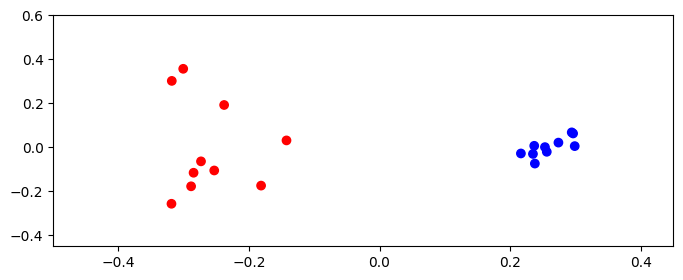

In [10]:
colors = ['red'] * 10 + ['blue'] * 10  # cow is red
plt.figure(figsize=(8,3))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors)
plt.xlim(-0.5, 0.45)
plt.ylim(-0.45, 0.6)
plt.show()

In [18]:
import os
plot_export_dir = 'plot_exports'
os.makedirs(plot_export_dir, exist_ok=True)

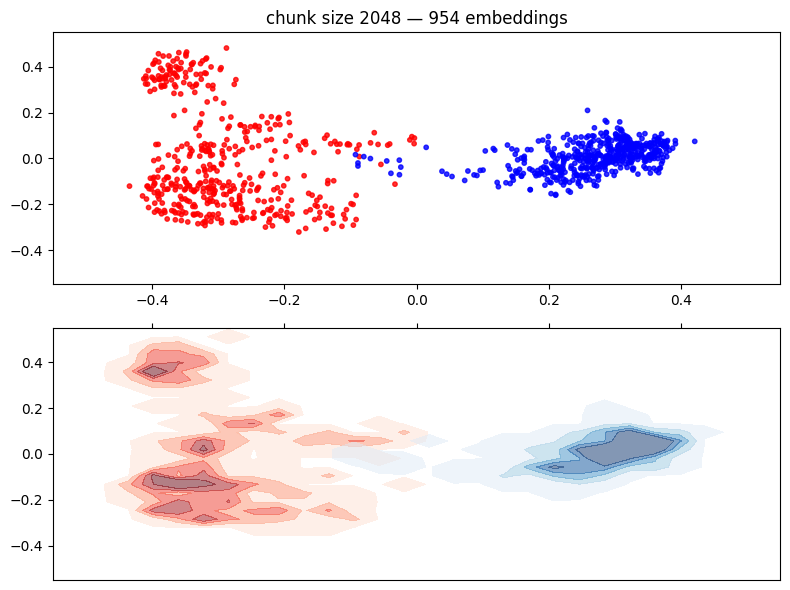

In [49]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon


def chunk_and_plot(chunk_size: int, alpha, size, save_path=None, figsize=(8, 4), prev_embedding=None, save_all_orientations=False):
    batch_size = min(32768 // chunk_size + 1, 1024)
    embeddings_cow = np.vstack([
        model.encode(chunk_text(paper, size=chunk_size, hard_cut=True), batch_size=batch_size)
        for paper in papers_cow
    ])
    embeddings_blackhole = np.vstack([
        model.encode(chunk_text(paper, size=chunk_size, hard_cut=True), batch_size=batch_size)
        for paper in papers_blackhole
    ])
    all_embeddings = np.vstack([embeddings_cow, embeddings_blackhole])
    reducer = PCA(n_components=2, random_state=42)
    base_embedding = reducer.fit_transform(all_embeddings)

    # since PCA might change data signs, orientation needs to be corrected to get consistent frames
    # Generate four candidate orientations.
    candidates = [
        base_embedding,
        np.column_stack((-base_embedding[:, 0], base_embedding[:, 1])),
        np.column_stack((base_embedding[:, 0], -base_embedding[:, 1])),
        np.column_stack((-base_embedding[:, 0], -base_embedding[:, 1])),
    ]
    
    def prep_plot(embeddings):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [1, 1]})
        # ---------- First plot: Scatter ----------
        colors = ['red'] * len(embeddings_cow) + ['blue'] * len(embeddings_blackhole)
        ax1.scatter(embeddings[:, 0], embeddings[:, 1], c=colors, alpha=alpha, s=size)
        ax1.set_xlim(-0.55, 0.55)
        ax1.set_ylim(-0.55, 0.55)
        ax1.set_title(f'chunk size {chunk_size} — {len(all_embeddings)} embeddings')
        
        # ---------- Second plot: Density ----------
        def plot_density(ax, points, color):
            x = points[:, 0]
            y = points[:, 1]
            n_bins = 30
            hist, xedges, yedges = np.histogram2d(x, y, bins=n_bins, range=[[-0.55, 0.55], [-0.55, 0.55]])
            hist_normalized = hist / np.sum(hist)
            xi, yi = np.meshgrid(np.linspace(xedges[0], xedges[-1], n_bins),
                                np.linspace(yedges[0], yedges[-1], n_bins))
            max_density = np.max(hist_normalized)
            levels = np.linspace(0.01 * max_density, 0.6 * max_density, 5)
            ax.contourf(xi, yi, hist_normalized.T, levels=levels, cmap=matplotlib.colormaps.get_cmap(color), alpha=0.5, extend='max')

        plot_density(ax2, embeddings[:len(embeddings_cow)], 'Reds')
        plot_density(ax2, embeddings[len(embeddings_cow):], 'Blues')

        ax2.set_xlim(-0.55, 0.55)
        ax2.set_ylim(-0.55, 0.55)
        ax2.xaxis.set_ticks_position('top')
        ax2.set_xticklabels([])

        plt.tight_layout()

    if save_all_orientations:
        for i, candidate in enumerate(candidates):
            prep_plot(candidate)
            plt.savefig(save_path.replace('.png', f'-{i}.png'), dpi=300, bbox_inches='tight')
            plt.close()
        return

    # choose best candidate
    if prev_embedding is None:
        best_embedding = candidates[0]
    else:
        prev_hull = ConvexHull(prev_embedding)
        prev_poly = Polygon(prev_embedding[prev_hull.vertices])
        
        def hull_intersection_area(candidate):
            hull = ConvexHull(candidate)
            poly = Polygon(candidate[hull.vertices])
            inter = poly.intersection(prev_poly)
            return inter.area if inter.is_valid else 0
        
        areas = np.array([hull_intersection_area(cand) for cand in candidates])
        best_embedding = candidates[np.argmax(areas)]
    
    # show results
    prep_plot(best_embedding)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

    return best_embedding
    

_ = chunk_and_plot(2048, alpha=0.8, size=10, figsize=(8,6))

[8192 7989 7791 7598 7409 7226 7047 6872 6702 6536 6374 6216 6062 5911
 5765 5622 5482 5347 5214 5085 4959 4836 4716 4599 4485 4374 4265 4160
 4057 3956 3858 3762 3669 3578 3489 3403 3319 3236 3156 3078 3002 2927
 2855 2784 2715 2648 2582 2518 2456 2395 2335 2277 2221 2166 2112 2060
 2009 1959 1910 1863 1817 1772 1728 1685 1643 1603 1563 1524 1486 1450
 1414 1379 1344 1311 1279 1247 1216 1186 1156 1128 1100 1073 1046 1020
  995  970  946  923  900  877  856  834  814  794  774  755  736  718
  700  683  666  649  633  617  602  587  573  558  545  531  518  505
  493  480  468  457  446  435  424  413  403  393  383  374  364  355
  347  338  330  322  314  306  298  291  284  277  270  263  256  250
  244  238  232  226  221  215  210  205  200  195  190  185  180  176
  172  167  163  159  155  151  148  144  140  137  134  130  127  124
  121  118  115  112  109  107  104  101   99   96   94   92   89   87
   85   83   81   79   77   75   73   71   70   68   66   64   63   61
   60 

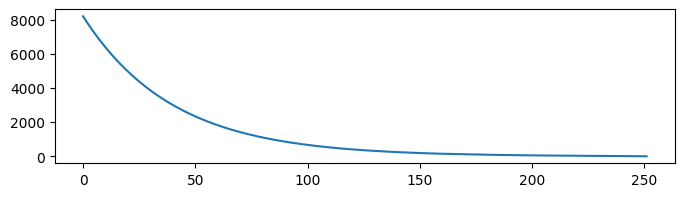

In [26]:
chunk_sizes = np.logspace(np.log10(8192), np.log10(1), 360)
chunk_sizes = np.round(chunk_sizes, 0).astype(np.int32)
chunk_sizes = np.sort(np.unique(chunk_sizes))[::-1]
print(chunk_sizes)

plt.figure(figsize=(8,2))
plt.plot(chunk_sizes)
plt.show()

In [35]:
N = len(chunk_sizes)
alphas = np.logspace(np.log10(1), np.log10(0.01), N)
sizes = np.logspace(np.log10(10), np.log10(1.5), N)

prev_embedding = None
for c, a, s in zip(chunk_sizes, alphas, sizes):
    if c in (8192,) or c < 8: # tmp to continue
        print(f'Processing {c}...')
        path = os.path.join(plot_export_dir, f'{c:04d}.png')
        prev_embedding = chunk_and_plot(chunk_size=c, alpha=a, size=s, figsize=(8, 6), save_path=path, prev_embedding=prev_embedding)#, save_all_orientations=True)

Processing 8192...
Processing 7...
Processing 6...
Processing 5...
Processing 4...
Processing 3...
Processing 2...
Processing 1...


In [55]:
output_files = os.listdir(plot_export_dir)
output_files = sorted(output_files, reverse=True)

for i, file in enumerate(output_files):
    new_name = f'frame_{i:04d}.png'
    os.rename(os.path.join(plot_export_dir, file), os.path.join(plot_export_dir, new_name))

In [ ]:
# ffmpeg -framerate 30 -i frame_%04d.png -vf "scale=ceil(in_w/2)*2:ceil(in_h/2)*2" -c:v libx264 -pix_fmt yuv420p output.mp4

---

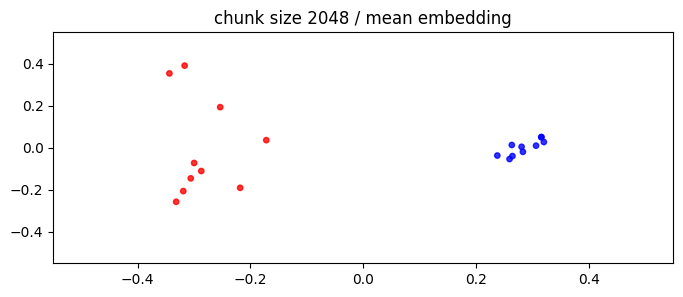

In [50]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon


def chunk_and_plot_mean(chunk_size: int, alpha, size, save_path=None, figsize=(8, 4), prev_embedding=None, save_all_orientations=False):
    batch_size = min(32768 // chunk_size + 1, 1024)
    embeddings_cow = np.vstack([
        np.mean(model.encode(chunk_text(paper, size=chunk_size, hard_cut=True), batch_size=batch_size), axis=0)
        for paper in papers_cow
    ])
    embeddings_blackhole = np.vstack([
        np.mean(model.encode(chunk_text(paper, size=chunk_size, hard_cut=True), batch_size=batch_size), axis=0)
        for paper in papers_blackhole
    ])
    all_embeddings = np.vstack([embeddings_cow, embeddings_blackhole])
    reducer = PCA(n_components=2, random_state=42)
    base_embedding = reducer.fit_transform(all_embeddings)

    # since PCA might change data signs, orientation needs to be corrected to get consistent frames
    # Generate four candidate orientations.
    candidates = [
        base_embedding,
        np.column_stack((-base_embedding[:, 0], base_embedding[:, 1])),
        np.column_stack((base_embedding[:, 0], -base_embedding[:, 1])),
        np.column_stack((-base_embedding[:, 0], -base_embedding[:, 1])),
    ]
    
    def prep_plot(embeddings):
        plt.figure(figsize=figsize)
        plt.title(f'chunk size {chunk_size} / mean embedding')
        colors = ['red'] * len(embeddings_cow) + ['blue'] * len(embeddings_blackhole)
        plt.scatter(embeddings[:, 0], embeddings[:, 1], c=colors, alpha=alpha, s=size)
        plt.xlim(-0.55, 0.55)
        plt.ylim(-0.55, 0.55)

    if save_all_orientations:
        for i, candidate in enumerate(candidates):
            prep_plot(candidate)
            plt.savefig(save_path.replace('.png', f'-{i}.png'), dpi=300, bbox_inches='tight')
            plt.close()
        return

    # choose best candidate
    if prev_embedding is None:
        best_embedding = candidates[0]
    else:
        prev_hull = ConvexHull(prev_embedding)
        prev_poly = Polygon(prev_embedding[prev_hull.vertices])
        
        def hull_intersection_area(candidate):
            hull = ConvexHull(candidate)
            poly = Polygon(candidate[hull.vertices])
            inter = poly.intersection(prev_poly)
            return inter.area if inter.is_valid else 0
        
        areas = np.array([hull_intersection_area(cand) for cand in candidates])
        best_embedding = candidates[np.argmax(areas)]
    
    # show results
    prep_plot(best_embedding)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

    return best_embedding
    

_ = chunk_and_plot_mean(2048, alpha=0.8, size=15, figsize=(8,3))

In [51]:
chunk_sizes = np.logspace(np.log10(8192), np.log10(1), 128)
chunk_sizes = np.round(chunk_sizes, 0).astype(np.int32)
chunk_sizes = np.sort(np.unique(chunk_sizes))[::-1]
print(chunk_sizes)

[8192 7631 7108 6621 6168 5745 5352 4985 4644 4326 4029 3753 3496 3257
 3034 2826 2632 2452 2284 2128 1982 1846 1720 1602 1492 1390 1295 1206
 1124 1047  975  908  846  788  734  684  637  593  553  515  480  447
  416  388  361  336  313  292  272  253  236  220  205  191  178  165
  154  144  134  125  116  108  101   94   87   81   76   71   66   61
   57   53   50   46   43   40   37   35   32   30   28   26   24   23
   21   20   18   17   16   15   14   13   12   11   10    9    8    7
    6    5    4    3    2    1]


In [54]:
N = len(chunk_sizes)

prev_embedding = None
for i, c in zip(
    range(N,),
    chunk_sizes,
):
    if c == 6: # tmp to continue
        print(f'Processing {c}...')
        path = os.path.join(plot_export_dir, f'{c:04d}.png')
        prev_embedding = chunk_and_plot_mean(chunk_size=c, alpha=0.8, size=15, figsize=(8, 3), save_path=path, prev_embedding=prev_embedding, save_all_orientations=True)

Processing 6...


---
# Data Analysis of some weird results..

In [17]:
chunk_size = 1
batch_size = min(32768 // chunk_size + 1, 1024)
embeddings_cow = np.vstack([
    np.mean(model.encode(chunk_text(paper, size=chunk_size, hard_cut=True), batch_size=batch_size), axis=0)
    for paper in papers_cow
])
embeddings_blackhole = np.vstack([
    np.mean(model.encode(chunk_text(paper, size=chunk_size, hard_cut=True), batch_size=batch_size), axis=0)
    for paper in papers_blackhole
])
all_embeddings = np.vstack([embeddings_cow, embeddings_blackhole])
reducer = PCA(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(all_embeddings)

(array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 17, 19]),)
(array([11, 12, 15, 16, 18]),)
(array([0, 2]),)


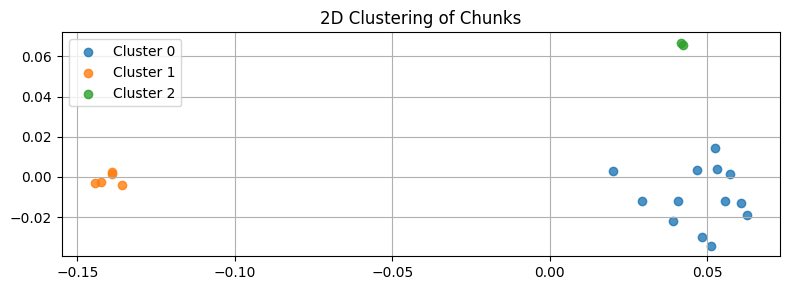

In [45]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Cluster
N = 3
kmeans = KMeans(n_clusters=N, random_state=42)
labels = kmeans.fit_predict(embedding_2d)

plt.figure(figsize=(8,3))
for cluster_id in range(N):
    indices = np.where(labels == cluster_id)
    print(indices)
    plt.scatter(embedding_2d[indices, 0], embedding_2d[indices, 1], label=f'Cluster {cluster_id}', alpha=0.8)

plt.title("2D Clustering of Chunks")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(array([1, 4, 5, 6, 7, 8, 9]),)
(array([ 3, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),)
(array([0, 2]),)


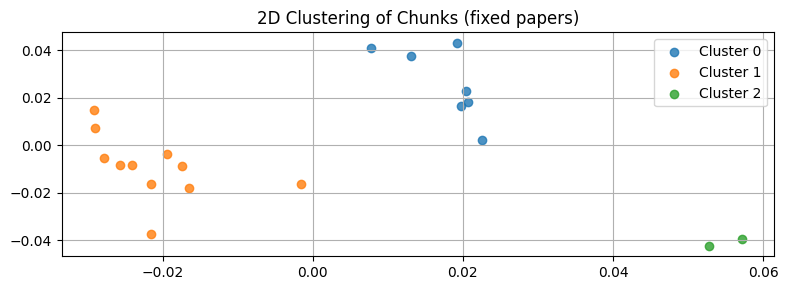

In [20]:
# with updated papers, fixed  

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Cluster
N = 3
kmeans = KMeans(n_clusters=N, random_state=42)
labels = kmeans.fit_predict(embedding_2d)

plt.figure(figsize=(8,3))
for cluster_id in range(N):
    indices = np.where(labels == cluster_id)
    print(indices)
    plt.scatter(embedding_2d[indices, 0], embedding_2d[indices, 1], label=f'Cluster {cluster_id}', alpha=0.8)

plt.title("2D Clustering of Chunks (fixed papers)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
paper_ids = papers_cow_ids + papers_blackhole_ids

for cluster_id in range(N):
    print(f'Cluster {cluster_id}')
    indices = np.where(labels == cluster_id)[0]
    for i in indices:
        print(f'- Paper: {paper_ids[i]}')

Cluster 0
- Paper: 1811.09918
- Paper: 1005.1381
- Paper: 2203.09606
- Paper: 2101.10445
- Paper: 2307.13994
- Paper: 2405.15550
- Paper: 2110.07103
- Paper: 2407.20372
- Paper: 1511.08596
- Paper: 0906.1492
- Paper: 1302.5116
- Paper: 0906.5351
- Paper: 1805.05051
Cluster 1
- Paper: astro-ph/0611950
- Paper: 0808.2870
- Paper: astro-ph/9809222
- Paper: astro-ph/0003433
- Paper: 0809.4677
Cluster 2
- Paper: 2105.09782
- Paper: 2106.03643


In [ ]:
for cluster_id in range(N):
    idx = np.where(labels == cluster_id)[0]
    print(f'Cluster {cluster_id}')
    for pi, paper in enumerate(papers):
        if pi in idx:
            print(f' - {len(paper)}')

Cluster 0
 - 25470
 - 64504
 - 33078
 - 42970
 - 38601
 - 75441
 - 22887
 - 66958
 - 20897
 - 64137
 - 68435
 - 22695
 - 91420
Cluster 1
 - 21382
 - 130103
 - 24530
 - 106261
 - 21652
Cluster 2
 - 32916
 - 61162


In [108]:
from collections import Counter

wordcounts = [
    [
        Counter(text)
        for pi, text in enumerate(papers)
        if pi in np.where(labels == i)[0]
    ]
    for i in range(N)
]

for wclist in wordcounts:
    for wc in wclist:
        print(wc.most_common()[:5])
    print("---")

wordcounts_flat = []
for list in wordcounts:
    wordcounts_flat.extend(list)

[(' ', 4068), ('e', 2331), ('t', 1797), ('a', 1666), ('i', 1527)]
[(' ', 12100), ('e', 4952), ('t', 3817), ('i', 3662), ('n', 3282)]
[(' ', 5175), ('e', 2670), ('i', 1921), ('a', 1786), ('t', 1686)]
[(' ', 6737), ('e', 3692), ('n', 2559), ('a', 2540), ('t', 2470)]
[(' ', 5811), ('e', 3336), ('a', 2604), ('t', 2447), ('i', 2281)]
[(' ', 12005), ('e', 6775), ('a', 4977), ('t', 4493), ('i', 4463)]
[(' ', 3571), ('e', 1826), ('o', 1512), ('a', 1479), ('t', 1376)]
[(' ', 9676), ('e', 6219), ('i', 4408), ('a', 4219), ('t', 4168)]
[(' ', 3539), ('e', 1667), ('t', 1227), ('a', 1163), ('o', 1121)]
[(' ', 11108), ('e', 6025), ('t', 4364), ('a', 4113), ('i', 3306)]
[(' ', 11912), ('e', 6144), ('t', 4521), ('a', 3821), ('i', 3548)]
[(' ', 4048), ('e', 1769), ('t', 1331), ('a', 1324), ('i', 1155)]
[(' ', 15484), ('e', 8266), ('t', 5663), ('a', 4852), ('i', 4563)]
---
[(' ', 7509), ('e', 1387), ('t', 1076), ('a', 973), ('s', 827)]
[(' ', 46651), ('e', 9073), ('t', 6465), ('a', 5688), ('i', 5101)]
[(

Cluster 0
Cluster 1
Cluster 2


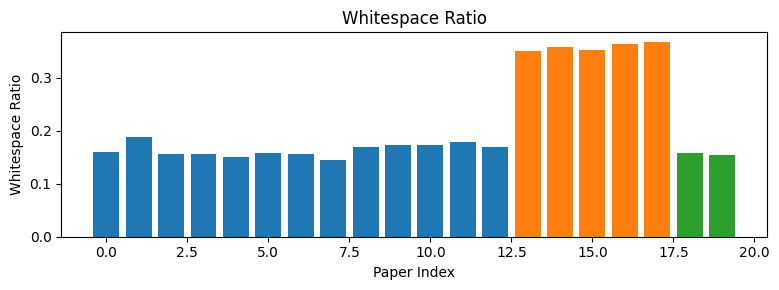

In [132]:
papers = papers_cow + papers_blackhole

import matplotlib
import matplotlib.pyplot as plt
colormap = matplotlib.colormaps['tab10']

colors = []
values = []

for cluster_id in range(N):
    idx = np.where(labels == cluster_id)[0]
    print(f'Cluster {cluster_id}')
    for pi, paper in enumerate(papers):
        if pi in idx:
            wc = Counter(paper)
            cc = len(paper)
            whitespace = wc.most_common()[0][1]
            whitespace_ratio = whitespace/cc
            colors.append(colormap(cluster_id))
            values.append(whitespace_ratio)


plt.figure(figsize=(8, 3))
plt.bar(range(len(values)), values, color=colors)
plt.xlabel('Paper Index')
plt.ylabel('Whitespace Ratio')
plt.title('Whitespace Ratio')
plt.tight_layout()
plt.show()

In [24]:
papers = papers_cow + papers_blackhole

In [25]:
papers[1]

'Abstract Identifying dairy cows with infections such as mastitis or cows on medications is an extremely important task and legally required by the FDA’s Pasteurized Milk Ordinance. The milk produced by these dairy cows cannot be allowed to mix with the milk from healthy cows or it risks contaminating the entire bulk tank or milk truck . Ear tags, ankle bands, RFID tags and even iris patterns are some of the identification methods currently used in the dairy farms. In this work we propose the use of NIR images of cow’s mammary gland s as a novel biometric identification modality. Two datasets, containing 302 samples from 151 cows has been collected and various machine learning techniques applied to demonstrate the viability of the proposed biometric modality. The results suggest promising identification accuracy for samples collected over consecutive days. 1. Introduction Sales of milk produced from dairy cows is a multi- billion-dollar industry [1]. It is crucial to ensure the quality

In [33]:
papers[18]

'arXiv:0809.4677v1 [astro-ph] 26 Sep 2008 A pproachi ng t he event hori zon: 1. 3m m \x15 V LB I of SgrA * Sheperd D oel em an M I T H ays t ac k O bs e r vat or y,O R out e 40,W e s t f or d,M A 01886,USA E- m ai l : sdoeleman@haystack.mit.edu A bst ract . A dvanc e si n V LBIi ns t r um e nt at i on now al l ow wi de band r e c or di ng t hats i gni c ant l y i nc r e as e s t he s e ns i t i vi t y of s hor t wave l e ngt h V LBI obs e r vat i ons . O bs e r vat i ons of t he s upe r - m as s i ve bl ac k hol e c andi dat e at t he c e nt e r of t he M i l ky W ay,Sgr A *, wi t h s hor t wave l e ngt h V LBIr e duc e st hes c at t e r i ng e e c t soft hei nt e r ve ni ng i nt e rs t e l l arm e di um ,al l owi ng obs e r vat i ons wi t h angul ar r e s ol ut i on c om par abl e t o t he appar e nt s i z e ofthe e ve nt hor i z on oft he put at i ve bl ac k hol e . O bs e r vat i ons i n A pr i l2007 at a wave l e ngt h of 1. 3m m on a t hr e e s t at i on V LBI ar r ay have now c o

^ weird spacing?

In [15]:
import pymupdf # imports the pymupdf library
doc = pymupdf.open('./arxiv_downloads/astro-ph_0611950v2.The_core_radius_of_a_star_cluster_containing_a_massive_black_hole.pdf') # open a document
text = ""
for page in doc: # iterate the document pages
  text += page.get_text() # get plain text encoded as UTF-8
text

'arXiv:astro-ph/0611950v2  12 Apr 2007\nPA SJ:Publ.A stron.Soc.Japan ,1{??,\nc\n\r\n2024.A stronom icalSociety ofJapan.\nT he C ore R adius ofa Star C luster C ontaining a M assive B lack H ole\nD ouglasC.H eggie\nSchoolofM athem atics and M axwellInstitute for M athem aticalSciences,U niversity ofEdinburgh,\nK ing’s Buildings,Edinburgh EH 9 3JZ,U K\nd.c.heggie@ ed.ac.uk\nPietH ut\nInstitute for Advanced Study,Princeton,N J 08540,U SA\npiet@ ias.edu\nShin M ineshige\nYukawa Institute for TheoreticalPhysics,K yoto U niversity,Sakyo-ku,K yoto 606-8502,Japan\nm inesige@ yukawa.kyoto-u.ac.jp\nJun M akino\nCenter for Com putationalA strophysics,N ationalA stronom icalO bservatory ofJapan,\n2-21-1 O hsawa,M itaka,Tokyo 181-8588,Japan\nm akino@ th.nao.ac.jp\nand\nHolgerB aumgardt\nArgelander Institute for A stronom y (A IfA ),Aufdem H \x7fugel71,53121 Bonn,G erm any\nholger@ astro.uni-bonn.de\n(R eceived 2006 D ecem ber1;accepted 2007 A pril10)\nA bstract\nW e presenta theoreticalfram ework w

In [22]:
# fixed pdf
import pymupdf # imports the pymupdf library
doc = pymupdf.open('./arxiv_downloads/astro-ph_0611950v2.The_core_radius_of_a_star_cluster_containing_a_massive_black_hole.pdf') # open a document
text = ""
for page in doc: # iterate the document pages
  text += page.get_text() # get plain text encoded as UTF-8
text

'arXiv:astro-ph/0611950v2  12 Apr 2007\nPASJ: Publ. Astron. Soc. Japan , 1–??,\nc\n⃝2021. Astronomical Society of Japan.\nThe Core Radius of a Star Cluster Containing a Massive Black Hole\nDouglas C. Heggie\nSchool of Mathematics and Maxwell Institute for Mathematical Sciences, University of Edinburgh,\nKing’s Buildings, Edinburgh EH9 3JZ, UK\nd.c.heggie@ed.ac.uk\nPiet Hut\nInstitute for Advanced Study, Princeton, NJ 08540, USA\npiet@ias.edu\nShin Mineshige\nYukawa Institute for Theoretical Physics, Kyoto University, Sakyo-ku, Kyoto 606-8502, Japan\nminesige@yukawa.kyoto-u.ac.jp\nJun Makino\nCenter for Computational Astrophysics, National Astronomical Observatory of Japan,\n2-21-1 Ohsawa, Mitaka, Tokyo 181-8588, Japan\nmakino@th.nao.ac.jp\nand\nHolger Baumgardt\nArgelander Institute for Astronomy (AIfA), Auf dem H¨ugel 71, 53121 Bonn, Germany\nholger@astro.uni-bonn.de\n(Received 2006 December 1; accepted 2007 April 10)\nAbstract\nWe present a theoretical framework which establishes how